# Libraries

In [515]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import torch
drive.mount('/content/drive')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Files

In [516]:
# train
pos_train = pd.read_csv("drive/MyDrive/IMDb/train/positive_train_full.csv", index_col=0)
pos_train["Encoded"] = 0
pos_train["Encoded"] = pos_train["Encoded"].astype(object)

neg_train = pd.read_csv("drive/MyDrive/IMDb/train/negative_train_full.csv", index_col=0)
neg_train["Encoded"] = 0
neg_train["Encoded"] = neg_train["Encoded"].astype(object)


# test
pos_test = pd.read_csv("drive/MyDrive/IMDb/test/positive_test_full.csv", index_col=0)
pos_test["Encoded"] = 0
pos_test["Encoded"] = pos_test["Encoded"].astype(object)

neg_test = pd.read_csv("drive/MyDrive/IMDb/test/negative_test_full.csv", index_col=0)
neg_test["Encoded"] = 0
neg_test["Encoded"] = neg_test["Encoded"].astype(object)



In [517]:
new_vocab = ""
dataframes = [neg_train, pos_train, pos_test, neg_test]

def remove_punc(review):
  #print(type(review))
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  for character in review:
    if(character in punc):
      review = review.replace(character, "")

  return review

for df in dataframes:
  for i,entry in df.iterrows():
    review = entry["Review"]
    review = remove_punc(review)
    #print(review)
    review_processed = review.lower().split(" ")
    #print(review_processed)
    for word in review_processed:
      new_vocab += " " + word


# Tokenizing

In [518]:
class WhiteSpaceTokenizer:
  """
  DESCRIPTION: This class is used to tokenize text. Textual data cannot be directly represented in tensors, so it
  is necessary to assign token ids to all of the words in a vocabulary

  INPUT: This object instantiation requires no input
  OUTPUT: The object instantiation returns an initialized WhiteSpaceTokenizer with the following callable methods:
    1. __len__(): returns the number of words in a vocabulary
    2. tokenize(text): This method returns a list of words/phrases using whitespace as the delimeter
      text: a string that requires tokenization
    3. fit(text): This method generates and assigns token ids for all words/phrases in text
      text: a string that requires tokenization
    4. encode(text): This method iterates through the token2id dictionary and extracts the token ids
      text: a string that requires tokenization
    5. decode(text): This method iterates through the token2id dictionary and extracts the tokens
  """
  def __init__(self, max_size: int = 300000000000000, unk_token: str = "[UNK]"):
    self.token2id = {}
    self.id2token = {}
    self.max_size = max_size
    self.unk_token_id = 1  # 0 is reserved for padding token, 1 is the tokenid for unseen words
    self.unk_token = unk_token

  def __len__(self):
    return len(self.token2id)
  
  def tokenize(self, text):
    # use python's split() as the built-in whitespace tokenizer, use lower-case letters
    return text.lower().split(" ")
  
  def fit(self, text):
    # Initialize token2id with the unknown id
    self.token2id = {self.unk_token: self.unk_token_id}
    #print("INCOMING TEXT: ", text)
    # for each word in the text input
    for token in self.tokenize(text):
      #print("TOKEN: ", token)
      # if there are less tokens than the max size and the current token is not in token2id dictionary
      if (token not in self.token2id):
        # add the current token to the token2id dictionary
        self.token2id[token] = (len(self.token2id) + 1)
      #print("Current token2id: ", self.token2id)
    # id2token is reverse mapping
    self.id2token = {int(v): k for k, v in self.token2id.items()}

  def encode(self, text):   
    token_ids = []
    # for each entity seperated by whitespace in the input text
    for token in self.tokenize(text):
      if(token in self.token2id):
        # collect and append the token of that word
        token_ids.append(self.token2id[token])
      else:
        token_ids.append(self.unk_token_id)
    return token_ids

  def decode(self, token_ids):
    tokens = []
    for token_id in token_ids:
      if (token_id > 1) and (token_id not in self.id2token):
        # token_id=1 is unknown
        token = "N/A"
      else:
        token = self.id2token[token_id]
      tokens.append(token)
    return tokens

In [519]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(new_vocab)

In [520]:
def remove_punc(review):
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  for character in review:
    if(character in punc):
      review = review.replace(character, "")

  return review

hmr = 0
for entry in neg_train.iterrows():
  review = entry[1]["Review"]
  review = remove_punc(review)
  tokenized_review = tokenizer.encode(review)
  
  if(1 in tokenized_review):
    print("ERROR")

  neg_train.at[hmr, "Encoded"]= tokenized_review
  hmr += 1

hmr = 0
for entry in pos_train.iterrows():
  review = entry[1]["Review"]
  review = remove_punc(review)
  tokenized_review = tokenizer.encode(review)
  if(1 in tokenized_review):
    print("ERROR")
  pos_train.at[hmr, "Encoded"]= tokenized_review
  hmr += 1

hmr = 0
for entry in neg_test.iterrows():
  review = entry[1]["Review"]
  review = remove_punc(review)
  tokenized_review = tokenizer.encode(review)
  if(1 in tokenized_review):
    print("ERROR")
  neg_test.at[hmr, "Encoded"]= tokenized_review
  hmr += 1

hmr = 0
for entry in pos_test.iterrows():
  review = entry[1]["Review"]
  review = remove_punc(review)
  tokenized_review = tokenizer.encode(review)
  if(1 in tokenized_review):
    print("ERROR")
  pos_test.at[hmr, "Encoded"]= tokenized_review
  hmr += 1

In [521]:
neg_train.head()

,ReviewID,titleid,titletype,primarytitle,originaltitle,isadult,startyear,endyear,runtimeminutes,genres,Review,Score,Encoded
0,0,tt0064354,movie,Futz,Futz,False,1969.0,NaN,92.0,"[""'Comedy'""]",Story of a man who has unnatural feelings for ...,3,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 5, 12, 13, 14, 1..."
1,1,tt0100680,movie,Stanley & Iris,Stanley & Iris,False,1990.0,NaN,104.0,"[""'Drama'"", ""'Romance'""]",Robert DeNiro plays the most unbelievably inte...,1,"[93, 94, 95, 34, 96, 97, 98, 99, 4, 100, 43, 1..."
2,2,tt0100680,movie,Stanley & Iris,Stanley & Iris,False,1990.0,NaN,104.0,"[""'Drama'"", ""'Romance'""]","I saw the capsule comment said ""great acting.""...",1,"[163, 164, 34, 165, 166, 167, 81, 168, 124, 16..."
3,3,tt0100680,movie,Stanley & Iris,Stanley & Iris,False,1990.0,NaN,104.0,"[""'Drama'"", ""'Romance'""]",If I had not read Pat Barker's 'Union Street' ...,4,"[225, 163, 226, 116, 227, 228, 229, 230, 231, ..."
4,4,tt0047200,movie,The Mad Magician,The Mad Magician,False,1954.0,NaN,72.0,"[""'Horror'"", ""'Mystery'"", ""'Thriller'""]",This fanciful horror flick has Vincent Price p...,4,"[101, 366, 367, 368, 8, 369, 370, 371, 5, 372,..."


# PyTorch 

In [522]:
from torch.nn.utils.rnn import pad_sequence


## Padding

In [523]:
# train
training_data = [neg_train, pos_train]
training_seq = []
target_train = []
for df in training_data:
  #print(df.shape)
  for i,row in df.iterrows():
    #print(row["Encoded"])
    training_seq.append(torch.FloatTensor(row["Encoded"]))
    #print(torch.FloatTensor(row["Encoded"]))
    #print(torch.FloatTensor([row["Score"]]))
    target_train.append(torch.FloatTensor([row["Score"]]))

padded_train = pad_sequence(training_seq, batch_first=True) 

# test
testing_data = [neg_test, pos_test]
testing_seq = []
target_test = []
for df in testing_data:
  for i, row in df.iterrows():
    testing_seq.append(torch.FloatTensor(row["Encoded"]))
    target_test.append(torch.FloatTensor([row["Score"]]))

padded_test = pad_sequence(testing_seq, batch_first=True) 

In [524]:
len(padded_test[10])

2278

In [525]:
len(padded_train[1])

2470

In [526]:
2470 - 2278


192

# Data Loading

In [527]:
class MLDataset:
  def __init__(self, xs, ys):
    self.xs = xs
    self.ys = ys
    
  def __getitem__(self, i):
    return self.xs[i], self.ys[i]
    
  def __len__(self):
    return len(self.xs)

In [528]:
from torch.utils.data import DataLoader

train_dataset = MLDataset(padded_train, target_train)
test_dataset = MLDataset(padded_test, target_test)

train_loader = DataLoader(train_dataset, batch_size = 2048)
test_loader = DataLoader(test_dataset, batch_size = 2048)

# MLP

In [600]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [601]:
print(device)
meta_diffs_save = []

cuda


In [602]:
vocab_size = len(tokenizer.token2id)

In [603]:
from sklearn.metrics import accuracy_score


class MLP(nn.Module):
  def __init__(self, maxlen):
    super().__init__()
    self.layers = nn.Sequential(nn.Flatten(), nn.Linear(maxlen, 2048), 
                                nn.LeakyReLU(), 
                                nn.Linear(2048, 1024),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Linear(1024,1024) ,
                                nn.LeakyReLU(), 
                                nn.BatchNorm1d(1024),
                                nn.Linear(1024, 512),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(512),
                                nn.Linear(512, 64),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(64),
                                nn.Linear(64, 12),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(12),
                                nn.Linear(12,12),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(12),
                                nn.Linear(12, 1),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(1)

                                )

  def forward(self, x):
    return self.layers(x)

In [604]:
samp = padded_test[0]
print(len(samp))
n = nn.functional.pad(samp, (1,191), "constant", 0)
len(n)

2278


2470

In [605]:
input_size = len(padded_train[0])
print(input_size)

mlp = MLP(input_size)
loss_fn = nn.MSELoss()

torch.manual_seed(50)

pred_analysis = {}

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-7)

results = []

for epoch in range(0,100):
  print("Epoch: ", epoch)
  # train
  tr_loss = 0.0

  for x, y in train_loader:
    mlp = mlp.to(device)
    x = x.to(device)
    output = mlp(x)

    y = y.to(device)
    loss = loss_fn(output, y)
    loss.backward()

    # step
    optimizer.step()

    # update loss 
    tr_loss += loss.item()

    
  print(tr_loss)

  # test
  test_loss = 0.0
  mlp.eval()

  yhat = []
  yreal = []
  hmr = 0
  for x, y in test_loader:
    x = x.to(device)
    x = nn.functional.pad(x, (1,191), "constant", 0)
    test_out = mlp(x)

    y = y.to(device)
    #if(epoch == 99)
    #print(test_out.shape[0])
    bsize = test_out.shape[0]

    if(epoch == 99):
      
      for i in range(bsize):
        yhat.append(test_out[i].tolist()[0])
        yreal.append(y[i].tolist()[0])


    #print(test_out[0].tolist()[0])
    #print(nn.Flatten(y))
    #kill = 3/0
    loss = loss_fn(test_out, y)

    loss.backward()
    optimizer.step()

    test_loss += loss.item()
    hmr += 1

  print(test_loss)






  new_row = {"Epoch":epoch, "Training_Loss":tr_loss, "Test_Loss":test_loss}
  results.append(new_row)


2470
Epoch:  0
584.7458624839783
529.2398238182068
Epoch:  1
600.7728652954102
529.2309160232544
Epoch:  2
600.7665853500366
529.2107877731323
Epoch:  3
600.755832195282
529.1785440444946
Epoch:  4
600.7404165267944
529.1296935081482
Epoch:  5
600.7148008346558
529.0574750900269
Epoch:  6
600.6752595901489
528.9499325752258
Epoch:  7
600.6176328659058
528.7850799560547
Epoch:  8
600.5348958969116
528.5293941497803
Epoch:  9
600.4031329154968
528.1298170089722
Epoch:  10
600.1814651489258
527.4764623641968
Epoch:  11
599.8141160011292
526.4477353096008
Epoch:  12
599.2290425300598
524.9209685325623
Epoch:  13
598.3495659828186
522.8008489608765
Epoch:  14
597.0553550720215
520.0390448570251
Epoch:  15
595.3121132850647
516.6791181564331
Epoch:  16
593.1176686286926
512.7882180213928
Epoch:  17
590.4817323684692
508.4492726325989
Epoch:  18
587.4623899459839
503.7621383666992
Epoch:  19
584.1399345397949
498.8259906768799
Epoch:  20
580.5568318367004
493.6982264518738
Epoch:  21
576.7631

10
3.9826509320969907
3.653916366837294
3.310600705026272
2.4934723858620824
-0.755933402099695
-1.8862142715813583
-3.1357301495327436
-4.795108168139063
[3.9826509320969907, 3.653916366837294, 3.310600705026272, 2.4934723858620824, -0.755933402099695, -1.8862142715813583, -3.1357301495327436, -4.795108168139063]


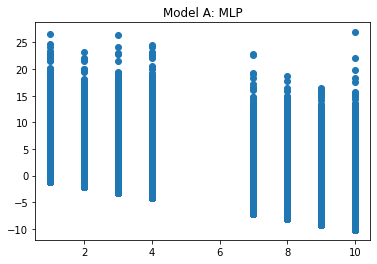

In [606]:
import matplotlib.pyplot as plt

difference = []

mean_diffs = [[],[],[],[],[],[],[],[],[],[]]
print(len(mean_diffs))
for i in range(len(yhat)):
  d = yhat[i] - float(yreal[i])
  difference.append(d)
  #print(int(yreal[i]))
  mean_diffs[(int(yreal[i])-1)].append(d)

final_mean_diffs = []

for i in range(len(mean_diffs)):
  try:
    print(sum(mean_diffs[i])/ len(mean_diffs[i]))
    avgd = sum(mean_diffs[i])/ len(mean_diffs[i])
    final_mean_diffs.append(avgd)
  except:
    print("", end= "")
    #final_mean_diffs.append(0)

print(final_mean_diffs)

xs = [1,2,3,4,7,8,9,10]

plt.title("Model A: MLP")
plt.scatter(yreal, difference)
plt.show()

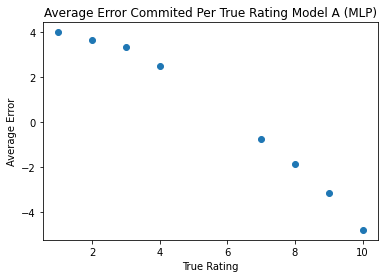

In [607]:
plt.scatter(xs, final_mean_diffs)
plt.title("Average Error Commited Per True Rating Model A (MLP)")
plt.xlabel("True Rating")
plt.ylabel("Average Error")
plt.show()
meta_diffs_save.append(final_mean_diffs)


In [552]:
yhat[0]

1.7926719188690186

In [553]:
yreal[0]

2.0

# Evaluation

In [160]:
df = pd.DataFrame(results)
df.head()

,Epoch,Training_Loss,Test_Loss
0,0,1093.888800,1036.243434
1,1,1111.788595,1008.816912
2,2,1078.789608,973.026877
3,3,1036.123724,933.233231
4,4,990.980523,894.327656


In [162]:
df.sort_values(by = "Training_Loss")

,Epoch,Training_Loss,Test_Loss
99,99,270.789808,314.674212
98,98,271.500530,315.104280
97,97,272.330869,315.498740
96,96,273.280838,315.859610
95,95,274.370808,316.178562
...,...,...,...
4,4,990.980523,894.327656
3,3,1036.123724,933.233231
2,2,1078.789608,973.026877
0,0,1093.888800,1036.243434


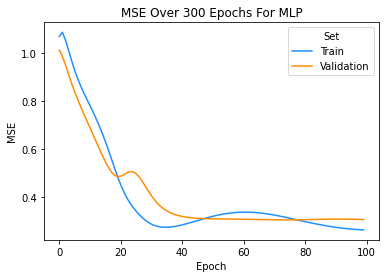

In [164]:
import matplotlib.pyplot as plt


plt.plot(df["Epoch"], df["Training_Loss"]/1024, color = "dodgerblue")
plt.plot(df["Epoch"], df["Test_Loss"]/1024, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 300 Epochs For MLP")
plt.legend(["Train", "Validation"], title = "Set" )

plt.show()

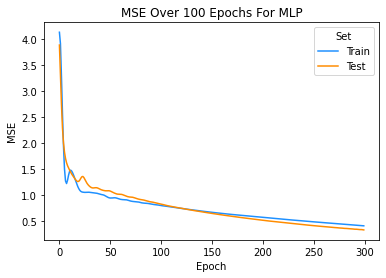

In [ ]:

plt.plot(df["Epoch"], df["Training_Loss"]/512, color = "dodgerblue")
plt.plot(df["Epoch"], df["Test_Loss"]/512, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 100 Epochs For MLP")
plt.legend(["Train", "Test"], title = "Set" )

plt.show()

In [ ]:
df3 = df

# RNN

In [608]:
#rnn = nn.RNN(input_size = 2470, hidden_size= 128, num_layers=1 , batch_first=True )


class RNN(nn.Module):
  def __init__(self):
    super().__init__()
    #self.layers = nn.Sequential(nn.RNN(input_size = 2470, hidden_size= 128, num_layers=1 , batch_first=True ), nn.Linear(128, 1))
    self.rnn_layer = nn.RNN(input_size = 2470, hidden_size= 512, num_layers=1 , batch_first=True, bidirectional = True )
    self.rnn2 =  nn.RNN(input_size = 1024, hidden_size= 256, num_layers=1 , batch_first=True, bidirectional = True )
    self.rnn3 = nn.RNN(input_size = 512, hidden_size = 128, num_layers=1 , batch_first=True, bidirectional = True)

    """
                                nn.Linear(128,128),
                                nn.Dropout(p=0.01),
                                nn.LeakyReLU(negative_slope=0.01),
                                #nn.BatchNorm1d(512),
                                nn.Linear(128, 64),
                                nn.Dropout(p=0.01),
                                nn.LeakyReLU(negative_slope=1),
                                nn.Linear(64,12),
                                nn.Dropout(p=0.01),
                                nn.LeakyReLU(negative_slope=0.01),
                                """

    self.layers = nn.Sequential( nn.Linear(256,12),
                                nn.Dropout(p=0.01),
                                nn.LeakyReLU(negative_slope=0.01), 
                                
                                nn.Linear(12,1),
                                nn.Dropout(p=0.01),
                                nn.LeakyReLU(negative_slope=0.01))
    """,
                                #nn.BatchNorm1d(256),
                                nn.Linear(256, 128),
                                nn.LeakyReLU(),
                                #nn.BatchNorm1d(128),
                                nn.Linear(128, 64),
                                nn.LeakyReLU(),
                                #nn.BatchNorm1d(64),
                                nn.Linear(64, 12),
                                nn.LeakyReLU(),
                                #nn.BatchNorm1d(12),
                                nn.Linear(12,12),
                                nn.LeakyReLU(),
                                nn.Linear(12, 1),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(1))"""

  def forward(self, x):
    hidden_states, _ = self.rnn_layer(x)
    last_hidden_state = hidden_states[:, -1, :] # Last hidden state

    last_hidden_state2 = torch.reshape(last_hidden_state, (last_hidden_state.shape[0], 1 , last_hidden_state.shape[1]))
    hidden_states, _ = self.rnn2(last_hidden_state2)

    last_hidden_state = hidden_states[:, -1, :]

    last_hidden_state3 = torch.reshape(last_hidden_state, (last_hidden_state.shape[0], 1 , last_hidden_state.shape[1]))
    hidden_states, _ = self.rnn3(last_hidden_state3)
    last_hidden_state = hidden_states[:, -1, :]

    out = self.layers(last_hidden_state)
    #out = self.leaky1(self.linear1(self.dropout(last_hidden_state)))
    #out = self.leaky1(self.linear2(out))
    #out = self.leaky1(self.linear3(out))

    return out, last_hidden_state

rnn = RNN()

loss_fn = nn.MSELoss()

torch.manual_seed(50)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-6)

results2 = []

for epoch in range(0,100):
  print("Epoch: ", epoch)
  # train
  tr_loss = 0.0
  rnn.train()

  for x, y in train_loader:
    rnn = rnn.to(device)
    x = x.to(device)
    #print(x.shape)
    #print(x.shape[0])
    x = torch.reshape(x,(x.shape[0],1, 2470))

    output, hidden = rnn(x)

    y = y.to(device)
    loss = loss_fn(output, y)
    loss.backward()

    # step
    optimizer.step()

    # update loss 
    tr_loss += loss.item()

    
  print(tr_loss)

  # test
  test_loss = 0.0
  rnn.eval()

  yhat = []
  yreal = []

  for x, y in test_loader:
    x = x.to(device)
    x = nn.functional.pad(x, (1,191), "constant", 0)
    x = torch.reshape(x,(x.shape[0],1, 2470))

    test_out,hidden = rnn(x)

    bsize = test_out.shape[0]

    if(epoch == 99):
      
      for i in range(bsize):
        yhat.append(test_out[i].tolist()[0])
        yreal.append(y[i].tolist()[0])

    y = y.to(device)
    loss = loss_fn(test_out, y)
    #loss.backward()
    optimizer.step()

    test_loss += loss.item()

  print(test_loss)






  new_row = {"Epoch":epoch, "Training_Loss":tr_loss, "Test_Loss":test_loss}
  results2.append(new_row)







"""
for x, y in train_loader:
  print(x[0])
  print(y[0])
  print(x.shape)
  x = torch.reshape(x,(512,1, 2470))
  print(x.shape)
  out, h_n = rnn(x) 
  break
"""

Epoch:  0
572.0655217170715
503.7477517127991
Epoch:  1
572.0327110290527
503.714515209198
Epoch:  2
571.9793992042542
503.6626362800598
Epoch:  3
571.8761925697327
503.5749535560608
Epoch:  4
571.7027287483215
503.4149556159973
Epoch:  5
571.3820042610168
503.12508487701416
Epoch:  6
570.7743048667908
502.60557746887207
Epoch:  7
569.6705160140991
501.6960196495056
Epoch:  8
567.7986164093018
500.2032194137573
Epoch:  9
564.7942667007446
497.96184730529785
Epoch:  10
560.6344299316406
494.8017039299011
Epoch:  11
555.2530555725098
490.75670337677
Epoch:  12
548.7610168457031
485.9050717353821
Epoch:  13
541.5929970741272
480.39503717422485
Epoch:  14
533.8475437164307
474.39062118530273
Epoch:  15
525.991409778595
468.0510730743408
Epoch:  16
517.6445631980896
461.5646376609802
Epoch:  17
509.62456130981445
454.92830657958984
Epoch:  18
501.4676549434662
448.2754936218262
Epoch:  19
493.47416949272156
441.6197624206543
Epoch:  20
485.5240571498871
434.9774947166443
Epoch:  21
477.8339

'\nfor x, y in train_loader:\n  print(x[0])\n  print(y[0])\n  print(x.shape)\n  x = torch.reshape(x,(512,1, 2470))\n  print(x.shape)\n  out, h_n = rnn(x) \n  break\n'

10
2.3268760812087916
1.3422035079329662
0.3566266908649383
-0.6377309439983042
-3.6113215139618626
-4.616145386556873
-5.624743058015635
-6.640417375862343
[2.3268760812087916, 1.3422035079329662, 0.3566266908649383, -0.6377309439983042, -3.6113215139618626, -4.616145386556873, -5.624743058015635, -6.640417375862343]


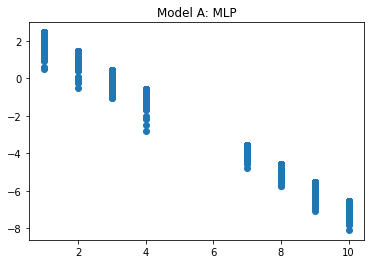

In [609]:
import matplotlib.pyplot as plt

difference = []

mean_diffs = [[],[],[],[],[],[],[],[],[],[]]
print(len(mean_diffs))
for i in range(len(yhat)):
  d = yhat[i] - float(yreal[i])
  difference.append(d)
  #print(int(yreal[i]))
  mean_diffs[(int(yreal[i])-1)].append(d)

final_mean_diffs = []

for i in range(len(mean_diffs)):
  try:
    print(sum(mean_diffs[i])/ len(mean_diffs[i]))
    avgd = sum(mean_diffs[i])/ len(mean_diffs[i])
    final_mean_diffs.append(avgd)
  except:
    print("", end= "")
    #final_mean_diffs.append(0)

print(final_mean_diffs)

xs = [1,2,3,4,7,8,9,10]

plt.title("Model A: MLP")
plt.scatter(yreal, difference)
plt.show()

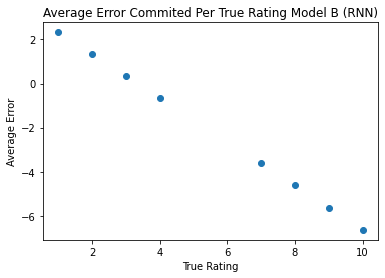

In [610]:
plt.scatter(xs, final_mean_diffs)
plt.title("Average Error Commited Per True Rating Model B (RNN)")
plt.xlabel("True Rating")
plt.ylabel("Average Error")
plt.show()
meta_diffs_save.append(final_mean_diffs)

In [209]:
df2 = pd.DataFrame(results2)
df2.head()

,Epoch,Training_Loss,Test_Loss
0,0,572.065522,503.747752
1,1,572.032711,503.714515
2,2,571.979399,503.662636
3,3,571.876193,503.574954
4,4,571.702729,503.414956


In [210]:
df2.sort_values(by = "Training_Loss")

,Epoch,Training_Loss,Test_Loss
99,99,224.146886,198.013521
98,98,225.603109,198.763322
97,97,226.522400,199.533224
96,96,227.566948,200.325632
95,95,228.370713,201.133093
...,...,...,...
4,4,571.702729,503.414956
3,3,571.876193,503.574954
2,2,571.979399,503.662636
1,1,572.032711,503.714515


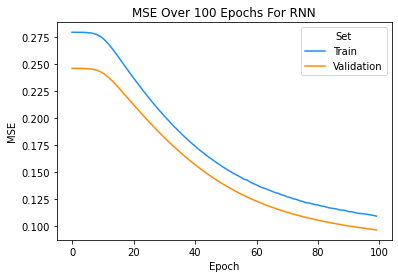

In [212]:
import matplotlib.pyplot as plt

batch_size = 2048
plt.plot(df2["Epoch"], df2["Training_Loss"]/batch_size, color = "dodgerblue")
plt.plot(df2["Epoch"], df2["Test_Loss"]/batch_size, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 100 Epochs For RNN")
plt.legend(["Train", "Validation"], title = "Set" )

plt.show()

# LSTM

In [611]:
#rnn = nn.RNN(input_size = 2470, hidden_size= 128, num_layers=1 , batch_first=True )
from torch.autograd import Variable 

class RNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.num_layers = 2
    self.hidden_size = 512
    #self.layers = nn.Sequential(nn.RNN(input_size = 2470, hidden_size= 128, num_layers=1 , batch_first=True ), nn.Linear(128, 1))
    self.rnn_layer = nn.LSTM(input_size = 2470, hidden_size= 512, num_layers=1 , batch_first=True, bidirectional = True)
    

    self.lrelu = nn.LeakyReLU()
    self.fc_1 =  nn.Linear(512, 128)
    self.fc = nn.Linear(128, 1)

    self.layers = nn.Sequential( nn.Linear(512,64),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01), 
                                
                                nn.Linear(64,12),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01),
                                nn.Linear(12,1),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01))

    self.layers2 = nn.Sequential(nn.Linear(512, 64),
                                nn.LeakyReLU(),
                                #nn.BatchNorm1d(512),
                                nn.Linear(64, 64),
                                nn.LeakyReLU(),
                                #nn.BatchNorm1d(512),
                                nn.Linear(64,12),
                                nn.LeakyReLU(),
                                #nn.BatchNorm1d(512),
                                nn.Linear(12, 12),
                                nn.LeakyReLU(),
                                nn.Linear(12, 1),
                                nn.LeakyReLU()
                                #nn.BatchNorm1d(1)
                                )


  def forward(self, x):
    #print("X: ", x.shape)
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
    h_0 = h_0.to(device)
    c_0 = c_0.to(device)

    # Propagate input through LSTM
    output, (hn, cn) = self.rnn_layer(x, (h_0,c_0))
    #print("O3: ", output.shape)
    #hn = hn.view(-1, self.hidden_size)
    out = hn
    out = self.layers(hn)
    #out = self.lrelu(hn)
    #print(out.shape)
    #out = self.fc_1(out)
    #out = self.lrelu(out)
    #out = self.fc(out)
    #print("O2: ", out.shape)
    return out

    """
    hidden_states, _ = self.rnn_layer(x)
    last_hidden_state = hidden_states[:, -1, :] # Last hidden state
    out = self.linear1(self.dropout(last_hidden_state))
    out = self.leaky1(self.linear2(out))
    #out = self.leaky1(self.linear3(out))

    return out, last_hidden_state
    """

rnn = RNN()

loss_fn = nn.MSELoss()

torch.manual_seed(50)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-5)

results3 = []

for epoch in range(0, 100):
  print("Epoch: ", epoch)
  # train
  tr_loss = 0.0
  rnn.train()

  for x, y in train_loader:
    rnn = rnn.to(device)
    x = x.to(device)
    #print(x.shape)
    #print(x.shape[0])
    x = torch.reshape(x,(x.shape[0],1, 2470))

    output = rnn(x)
    #print("O: ", output.shape)

    y = y.to(device)
    loss = loss_fn(output, y)
    loss.backward()

    # step
    optimizer.step()

    # update loss 
    tr_loss += loss.item()

    
  print(tr_loss)

  # test
  test_loss = 0.0
  rnn.eval()

  yhat = []
  yreal = []

  for x, y in test_loader:
    x = x.to(device)
    x = nn.functional.pad(x, (1,191), "constant", 0)
    x = torch.reshape(x,(x.shape[0],1, 2470))

    test_out,hidden = rnn(x)

    if(epoch == 99):
      for i in range(bsize):
        yhat.append(test_out[i].tolist()[0])
        yreal.append(y[i].tolist()[0])

    y = y.to(device)
    loss = loss_fn(test_out, y)
    #loss.backward()
    optimizer.step()

    test_loss += loss.item()

  print(test_loss)






  new_row = {"Epoch":epoch, "Training_Loss":tr_loss, "Test_Loss":test_loss}
  results3.append(new_row)







"""
for x, y in train_loader:
  print(x[0])
  print(y[0])
  print(x.shape)
  x = torch.reshape(x,(512,1, 2470))
  print(x.shape)
  out, h_n = rnn(x) 
  break
"""

Epoch:  0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2048, 1])) that is different to the input size (torch.Size([2, 2048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([424, 1])) that is different to the input size (torch.Size([2, 424, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


571.9984316825867
503.6975955963135
Epoch:  1
571.9753274917603
503.6766128540039
Epoch:  2
571.9448404312134
503.64927196502686
Epoch:  3
571.9075412750244
503.6139163970947
Epoch:  4
571.8482689857483
503.5368595123291
Epoch:  5
571.5755443572998
503.0497121810913
Epoch:  6
569.6203875541687
500.3114733695984
Epoch:  7
562.3984980583191
492.60542726516724
Epoch:  8
548.2319617271423
479.68077421188354
Epoch:  9
528.6456456184387
462.59968423843384
Epoch:  10
504.9230070114136
442.3463521003723
Epoch:  11
477.9182720184326
419.47500801086426
Epoch:  12
448.31437826156616
394.6511673927307
Epoch:  13
417.0311380624771
368.10434079170227
Epoch:  14
384.8617579936981
340.6703989505768
Epoch:  15
352.6760503053665
312.88662016391754
Epoch:  16
321.58289432525635
285.55012834072113
Epoch:  17
292.26099836826324
259.26375329494476
Epoch:  18
265.72242546081543
234.8220683336258
Epoch:  19
242.5112645626068
212.96940994262695
Epoch:  20
223.2632532119751
194.0364899635315
Epoch:  21
208.3286

'\nfor x, y in train_loader:\n  print(x[0])\n  print(y[0])\n  print(x.shape)\n  x = torch.reshape(x,(512,1, 2470))\n  print(x.shape)\n  out, h_n = rnn(x) \n  break\n'

10
5.15652894005037
4.172389991095617
3.189596166873114
2.212981247612859
-0.7778056215130116
-1.7688372725759531
-2.786206452916357
-3.7930758493953873
[5.15652894005037, 4.172389991095617, 3.189596166873114, 2.212981247612859, -0.7778056215130116, -1.7688372725759531, -2.786206452916357, -3.7930758493953873]


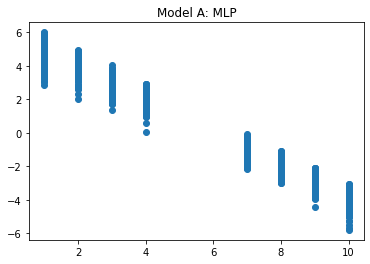

In [612]:
import matplotlib.pyplot as plt

difference = []

mean_diffs = [[],[],[],[],[],[],[],[],[],[]]
print(len(mean_diffs))
for i in range(len(yhat)):
  d = yhat[i] - float(yreal[i])
  difference.append(d)
  #print(int(yreal[i]))
  mean_diffs[(int(yreal[i])-1)].append(d)

final_mean_diffs = []

for i in range(len(mean_diffs)):
  try:
    print(sum(mean_diffs[i])/ len(mean_diffs[i]))
    avgd = sum(mean_diffs[i])/ len(mean_diffs[i])
    final_mean_diffs.append(avgd)
  except:
    print("", end= "")
    #final_mean_diffs.append(0)

print(final_mean_diffs)

xs = [1,2,3,4,7,8,9,10]

plt.title("Model A: MLP")
plt.scatter(yreal, difference)
plt.show()

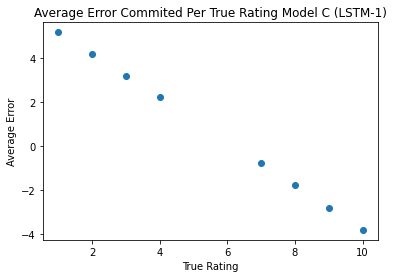

In [613]:
plt.scatter(xs, final_mean_diffs)
plt.title("Average Error Commited Per True Rating Model C (LSTM-1)")
plt.xlabel("True Rating")
plt.ylabel("Average Error")
plt.show()
meta_diffs_save.append(final_mean_diffs)

In [204]:
df3 = pd.DataFrame(results3)
df3.head()

,Epoch,Training_Loss,Test_Loss
0,0,571.998432,503.697596
1,1,571.975327,503.676613
2,2,571.944840,503.649272
3,3,571.907541,503.613916
4,4,571.848269,503.536860


In [205]:
df3.sort_values(by = "Training_Loss")

,Epoch,Training_Loss,Test_Loss
76,76,155.839399,142.923285
77,77,155.923751,143.386395
75,75,156.236891,142.871583
78,78,156.446977,144.258665
74,74,157.099553,143.252933
...,...,...,...
4,4,571.848269,503.536860
3,3,571.907541,503.613916
2,2,571.944840,503.649272
1,1,571.975327,503.676613


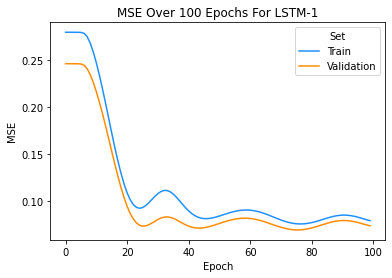

In [207]:
import matplotlib.pyplot as plt
batch_size = 2048
plt.plot(df3["Epoch"], df3["Training_Loss"]/batch_size, color = "dodgerblue")
plt.plot(df3["Epoch"], df3["Test_Loss"]/batch_size, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 100 Epochs For LSTM-1")
plt.legend(["Train", "Validation"], title = "Set" )

plt.show()

# LSTM - 2 

In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM1(nn.ModuleList):
  def __init__(self):
    super(LSTM1, self).__init__()
    # Number of samples per time step
    self.batch_size = 1024
    
    # Dimension of weight vectors
    self.hidden_dim = 1
    
    # Dimension of embedded tensor
    self.embedding_dim = 1235
    
    # The vocabulary size
    self.input_size = 2470
    
    # Number of time steps
    self.sequence_len = 2
    
    # Initialize embedding layer
    self.embedding = nn.Embedding(self.input_size, self.embedding_dim, padding_idx=0)
    
    # Initialize LSTM Cell
    self.lstm_cell = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
  def forward(self, x):
	
    # Creation of cell state and hidden state
    hidden_state = torch.zeros(x.size(0), self.hidden_dim)
    cell_state = torch.zeros(x.size(0), self.hidden_dim)
    
    hidden_state = hidden_state.to(device)
    cell_state = cell_state.to(device)
    
    # Weights initialization
    torch.nn.init.xavier_normal_(hidden_state)
    torch.nn.init.xavier_normal_(cell_state)
    
    # From idx-token to embedded tensors
    #print("X Shape: ", x.shape)
    #out = self.embedding(x)
    out = x
    #print("Out Shape: ", out.shape)
    
    # Prepare the shape for LSTMCell
    out = out.view(self.sequence_len, x.size(0), -1)
    #print("Out Shape 2: ", out.shape)
    
    # Unfolding LSTM
    for i in range(self.sequence_len):
      hidden_state, cell_state = self.lstm_cell(out[i], (hidden_state, cell_state))
      
    return hidden_state

In [402]:
# LSTM 2
class LSTM2(nn.ModuleList):
  def __init__(self):
    super(LSTM2, self).__init__()
    # Number of samples per time step
    self.batch_size = 2048
    
    # Dimension of weight vectors
    self.hidden_dim = 128
    
    # Dimension of embedded tensor
    self.embedding_dim = 1235
    
    # The vocabulary size
    self.input_size = 2470
    
    # Number of time steps
    self.sequence_len = 2
    
    # Initialize embedding layer
    self.embedding = nn.Embedding(self.input_size, self.embedding_dim, padding_idx=0)
    
    # Initialize LSTM Cell
    self.lstm_cell = nn.LSTMCell(self.embedding_dim, self.hidden_dim)


    # Initialize LSTM Cell for the first layer
    self.lstm_cell_1 = nn.LSTMCell(self.embedding_dim, self.hidden_dim)

    # Initialize LSTM Cell for the second layer
    self.lstm_cell_2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)

    self.fully_connected = nn.Linear(128, 64)
    self.lrelu = nn.LeakyReLU(negative_slope=2)
    self.nrelu = nn.LeakyReLU(negative_slope=2)
    self.fc2 = nn.Linear(64, 1)
    self.fc3 = nn.Linear(12, 1)


    self.layers = nn.Sequential( nn.Linear(128,64),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01), 
                                
                                nn.Linear(64,12),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01),
                                nn.Linear(12,1),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01))


  def forward(self, x):
	
    # batch_size x hidden_size
    hidden_state = torch.zeros(x.size(0), self.hidden_dim)
    cell_state = torch.zeros(x.size(0), self.hidden_dim)
    hidden_state_2 = torch.zeros(x.size(0), self.hidden_dim)
    cell_state_2 = torch.zeros(x.size(0), self.hidden_dim)

    hidden_state = hidden_state.to(device)
    cell_state = cell_state.to(device)
    hidden_state_2 = hidden_state_2.to(device)
    cell_state_2 = cell_state_2.to(device)
    
    # weights initialization
    torch.nn.init.xavier_normal_(hidden_state)
    torch.nn.init.xavier_normal_(cell_state)
    torch.nn.init.xavier_normal_(hidden_state_2)
    torch.nn.init.xavier_normal_(cell_state_2)
    
    # From idx to embedding
    #out = self.embedding(x)
    out = x
    
    # Prepare the shape for LSTMCell
    out = out.view(self.sequence_len, x.size(0), -1)
    
    # Unfolding LSTM
    # Last hidden_state will be used to feed the fully connected neural net
    for i in range(self.sequence_len):
      hidden_state, cell_state = self.lstm_cell_1(out[i], (hidden_state, cell_state))
      hidden_state_2, cell_state_2 = self.lstm_cell_2(hidden_state, (hidden_state_2, cell_state_2))
      
    # Last hidden state is passed through a fully connected neural net
    #print(hidden_state_2.shape)
    out = self.layers(hidden_state_2)
    #out = self.fully_connected(hidden_state_2)	
    #out = self.lrelu(out)
    #out = self.fc2(out)
    #out = self.nrelu(out)
    #out = self.fc3(out)    
    return out

In [403]:
#rnn = nn.RNN(input_size = 2470, hidden_size= 128, num_layers=1 , batch_first=True )
from torch.autograd import Variable 

rnn = LSTM2()

loss_fn = nn.MSELoss()

torch.manual_seed(50)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-5)

results4 = []

for epoch in range(0,150):
  print("Epoch: ", epoch)
  # train
  tr_loss = 0.0
  rnn.train()

  for x, y in train_loader:
    rnn = rnn.to(device)
    x = x.to(device)
    #print(x.shape)
    #print(x.shape[0])
    x = torch.reshape(x,(x.shape[0],1, 2470))
    #x = x.long()

    output = rnn(x)
    #print("O: ", output.shape)

    y = y.to(device)
    loss = loss_fn(output, y)
    loss.backward()

    # step
    optimizer.step()

    # update loss 
    tr_loss += loss.item()

    
  print(tr_loss)

  # test
  test_loss = 0.0
  rnn.eval()

  
  for x, y in test_loader:
    x = x.to(device)
    x = nn.functional.pad(x, (1,191), "constant", 0)
    x = torch.reshape(x,(x.shape[0],1, 2470))

    test_out = rnn(x)

    bsize = test_out.shape[0]

    

    y = y.to(device)
    loss = loss_fn(test_out, y)
    #loss.backward()
    optimizer.step()

    test_loss += loss.item()

  print(test_loss)






  new_row = {"Epoch":epoch, "Training_Loss":tr_loss, "Test_Loss":test_loss}
  results4.append(new_row)







"""
for x, y in train_loader:
  print(x[0])
  print(y[0])
  print(x.shape)
  x = torch.reshape(x,(512,1, 2470))
  print(x.shape)
  out, h_n = rnn(x) 
  break
"""

Epoch:  0
571.722011089325
503.45845890045166
Epoch:  1
571.717698097229
503.454270362854
Epoch:  2
571.712384223938
503.44939708709717
Epoch:  3
571.7064723968506
503.44416332244873
Epoch:  4
571.7000994682312
503.43822383880615
Epoch:  5
571.6914148330688
503.4287233352661
Epoch:  6
571.6599678993225
503.3815426826477
Epoch:  7
571.476722240448
503.15785217285156
Epoch:  8
570.91486120224
502.59034538269043
Epoch:  9
569.9369192123413
501.7111225128174
Epoch:  10
568.6513600349426
500.4183831214905
Epoch:  11
566.6727409362793
498.60990047454834
Epoch:  12
564.3082275390625
496.5587272644043
Epoch:  13
561.6052165031433
494.2238988876343
Epoch:  14
558.4870581626892
491.5374584197998
Epoch:  15
554.8846645355225
488.40189361572266
Epoch:  16
550.6193265914917
484.7224655151367
Epoch:  17
545.6861619949341
480.45538568496704
Epoch:  18
539.9442052841187
475.5343322753906
Epoch:  19
533.2399101257324
469.7257413864136
Epoch:  20
525.2735257148743
462.69933795928955
Epoch:  21
515.78625

'\nfor x, y in train_loader:\n  print(x[0])\n  print(y[0])\n  print(x.shape)\n  x = torch.reshape(x,(512,1, 2470))\n  print(x.shape)\n  out, h_n = rnn(x) \n  break\n'

In [197]:
#device = "cuda"

In [198]:
df4 = pd.DataFrame(results4)
df4.head()



,Epoch,Training_Loss,Test_Loss
0,0,571.946454,503.657888
1,1,571.942441,503.654031
2,2,571.937607,503.649617
3,3,571.932324,503.645019
4,4,571.926931,503.640352


In [202]:
df4.sort_values(by = "Training_Loss")

,Epoch,Training_Loss,Test_Loss
99,99,201.262475,181.954710
98,98,202.715850,182.935975
97,97,203.208334,183.822592
96,96,204.007402,184.609153
95,95,204.837796,185.394363
...,...,...,...
4,4,571.926931,503.640352
3,3,571.932324,503.645019
2,2,571.937607,503.649617
1,1,571.942441,503.654031


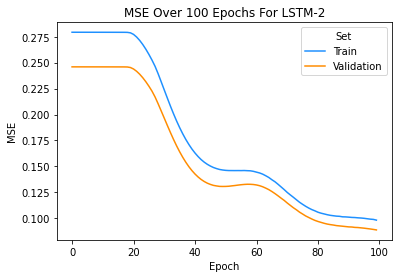

In [201]:
import matplotlib.pyplot as plt

batch_size = 2048

plt.plot(df4["Epoch"], df4["Training_Loss"]/batch_size, color = "dodgerblue")
plt.plot(df4["Epoch"], df4["Test_Loss"]/batch_size, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 100 Epochs For LSTM-2")
plt.legend(["Train", "Validation"], title = "Set" )

plt.show()

# GRU

In [614]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.1):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)

        self.layers = nn.Sequential(nn.Linear(hidden_dim, 128),
                                    nn.LeakyReLU(),
                                    nn.Linear(128, 70),
                                    nn.LeakyReLU(),
                                    nn.Linear(70, 64),
                                    nn.LeakyReLU(),
                                    nn.Linear(64, 32),
                                    nn.Linear(32, 16),
                                    nn.Linear(16,1)
                                    )
        self.layers3 = nn.Sequential(nn.Linear(1024, 64), nn.LeakyReLU(), nn.Linear(64,64), nn.LeakyReLU(), nn.Linear(64,1), nn.LeakyReLU())
        self.layers2 = nn.Sequential(nn.Flatten(),
                                nn.Linear(1024, 512),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(512),
                                nn.Dropout(p = 0.2),
                                nn.Linear(512, 64),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(64),
                                nn.Dropout(p = 0.2),
                                nn.Linear(64, 12),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(12),
                                nn.Dropout(p = 0.2),
                                nn.Linear(12,12),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(12),
                                nn.Dropout(p = 0.2),
                                nn.Linear(12, 10),
                                nn.LeakyReLU(),
                                nn.Linear(10,5),
                                nn.LeakyReLU(),
                                nn.Linear(5,5),
                                nn.LeakyReLU(),
                                nn.Linear(5,1),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(1)

                                )
        """
        self.fc = nn.Linear(hidden_dim, 128)
        self.relu = nn.LeakyReLU(negative_slope = 0.01)
        self.fc_bn = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(128, 70)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(70, 64)
        self.fc3_bn = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(64, 32)
        self.fc4_bn = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(32, 16)
        self.fc5_bn = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(16,1)
        """


        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.layers2(out)
        #out = self.fc(self.relu(self.fc_bn(out[:,-1])))
        #out = self.fc2(self.relu(self.fc2_bn(out)))
        #out = self.fc3(self.relu(self.fc3_bn(out)))
        #out = self.fc4(self.relu(self.fc4_bn(out)))
        #out = self.fc5(self.relu(self.fc5_bn(out)))
        #out = self.fc6(self.relu(out))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [619]:
rnn = GRUNet(2470, 1024, 2, 1)

loss_fn = nn.MSELoss()

torch.manual_seed(40)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-4)

results5 = []

for epoch in range(0,100):
  print("Epoch: ", epoch)
  # train
  tr_loss = 0.0
  rnn.train()

  for x, y in train_loader:
    rnn = rnn.to(device)
    x = x.to(device)
    #print(x.shape)
    #print(x.shape[0])
    x = torch.reshape(x,(x.shape[0],1, 2470))
    #x = x.long()
    #kill = 3/0


    h = rnn.init_hidden(x.shape[0])
    h = h.data

    output,h = rnn(x, h)
    #print("O: ", output.shape)

    y = y.to(device)
    loss = loss_fn(output, y)
    loss.backward()

    # step
    optimizer.step()

    # update loss 
    tr_loss += loss.item()

    
  print(tr_loss)

  # test
  test_loss = 0.0
  rnn.eval()

  yhat = []
  yreal = []

  for x, y in test_loader:
    x = x.to(device)
    x = nn.functional.pad(x, (1,191), "constant", 0)
    x = torch.reshape(x,(x.shape[0],1, 2470))

    h = rnn.init_hidden(x.shape[0])
    h = h.data

    test_out,h = rnn(x,h)
    bsize = test_out.shape[0]

    if(epoch == 99):
      
      for i in range(bsize):
        yhat.append(test_out[i].tolist()[0])
        yreal.append(y[i].tolist()[0])

    y = y.to(device)
    loss = loss_fn(test_out, y)
    #loss.backward()
    optimizer.step()

    test_loss += loss.item()

  print(test_loss)


  new_row = {"Epoch":epoch, "Training_Loss":tr_loss, "Test_Loss":test_loss}
  results5.append(new_row)





/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch:  0
571.2991209030151
500.7385506629944
Epoch:  1
566.5482234954834
496.68131589889526
Epoch:  2
561.6860976219177
492.142071723938
Epoch:  3
556.4343056678772
487.90920305252075
Epoch:  4
550.9998908042908
483.794903755188
Epoch:  5
545.4797148704529
479.79422426223755
Epoch:  6
539.917486667633
475.87819814682007
Epoch:  7
534.3772864341736
471.9646053314209
Epoch:  8
528.8158297538757
467.64745140075684
Epoch:  9
523.310703754425
462.5071063041687
Epoch:  10
517.8117728233337
457.1150584220886
Epoch:  11
512.3606534004211
451.5122022628784
Epoch:  12
506.92629766464233
445.7737383842468
Epoch:  13
501.6204237937927
450.4794592857361
Epoch:  14
496.26682567596436
447.135461807251
Epoch:  15
490.993248462677
440.9516348838806
Epoch:  16
485.7620759010315
434.73462295532227
Epoch:  17
480.602251291275
428.92609667778015
Epoch:  18
475.47026562690735
423.4586727619171
Epoch:  19
470.4036841392517
418.31834864616394
Epoch:  20
465.3891131877899
413.3014979362488
Epoch:  21
460.4249

10
24232
2.5502254335303935
1.5507912597482252
0.5512687110000124
-0.4498274745253503
-3.442553816239039
-4.442064516836574
-5.44343492243741
-6.442504580965197
[2.5502254335303935, 1.5507912597482252, 0.5512687110000124, -0.4498274745253503, -3.442553816239039, -4.442064516836574, -5.44343492243741, -6.442504580965197]


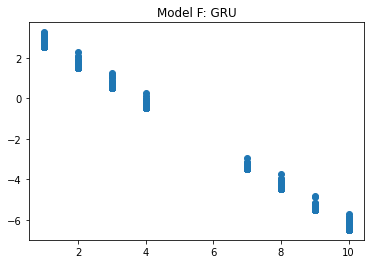

In [620]:
import matplotlib.pyplot as plt

difference = []

mean_diffs = [[],[],[],[],[],[],[],[],[],[]]
print(len(mean_diffs))
print(len(yhat))
for i in range(len(yhat)):
  d = yhat[i] - float(yreal[i])
  difference.append(d)
  #print(int(yreal[i]))
  mean_diffs[(int(yreal[i])-1)].append(d)

final_mean_diffs = []

for i in range(len(mean_diffs)):
  try:
    print(sum(mean_diffs[i])/ len(mean_diffs[i]))
    avgd = sum(mean_diffs[i])/ len(mean_diffs[i])
    final_mean_diffs.append(avgd)
  except:
    print("", end= "")
    #final_mean_diffs.append(0)

print(final_mean_diffs)

xs = [1,2,3,4,7,8,9,10]

plt.title("Model F: GRU")
plt.scatter(yreal, difference)
plt.show()


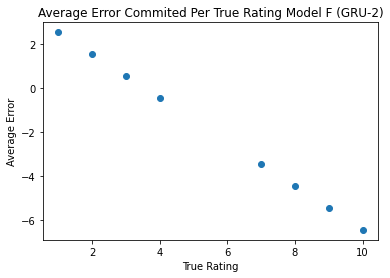

In [621]:
plt.scatter(xs, final_mean_diffs)
plt.title("Average Error Commited Per True Rating Model F (GRU-2)")
plt.xlabel("True Rating")
plt.ylabel("Average Error")
plt.show()
meta_diffs_save.append(final_mean_diffs)


In [338]:
df5 = pd.DataFrame(results5)
df5.head()


,Epoch,Training_Loss,Test_Loss
0,0,570.626933,500.797830
1,1,566.529037,496.825865
2,2,561.678892,492.462719
3,3,556.439290,488.313070
4,4,551.002907,484.302573


In [339]:
df5.sort_values(by = "Training_Loss").head()

,Epoch,Training_Loss,Test_Loss
176,176,153.723663,147.409767
178,178,153.737676,148.111499
177,177,153.739826,147.742430
175,175,153.759667,147.138999
167,167,153.798573,146.313527


In [340]:
df5.sort_values(by = "Test_Loss").head()

,Epoch,Training_Loss,Test_Loss
168,168,153.807118,146.269155
169,169,153.833398,146.284165
167,167,153.798573,146.313527
170,170,153.869457,146.335006
166,166,153.834127,146.400681


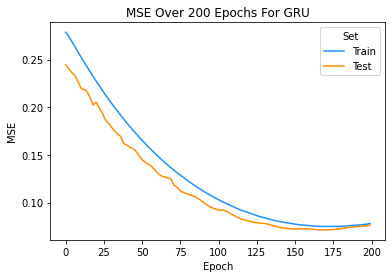

In [341]:
import matplotlib.pyplot as plt

plt.plot(df5["Epoch"], df5["Training_Loss"]/2048, color = "dodgerblue")
plt.plot(df5["Epoch"], df5["Test_Loss"]/2048, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 200 Epochs For GRU")
plt.legend(["Train", "Test"], title = "Set" )

plt.show()

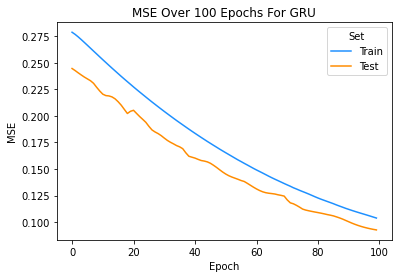

In [336]:
import matplotlib.pyplot as plt

plt.plot(df5["Epoch"], df5["Training_Loss"]/2048, color = "dodgerblue")
plt.plot(df5["Epoch"], df5["Test_Loss"]/2048, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 100 Epochs For GRU")
plt.legend(["Train", "Test"], title = "Set" )

plt.show()

# GRU-2

In [396]:
class GRUNet(nn.Module):
    def __init__(self):
        super(GRUNet, self).__init__()
        #self.hidden_dim = hidden_dim
        #self.n_layers = n_layers
        
        self.gru  = nn.GRU(2470, 256, 1, batch_first=True, dropout= 0.2 )
        self.gru2 = nn.GRU(256, 256, 1, batch_first=True, dropout= 0.2 )

        self.layers = nn.Sequential(nn.Linear(256, 128),
                                    nn.LeakyReLU(),
                                    nn.Linear(128, 70),
                                    nn.LeakyReLU(),
                                    nn.Linear(70, 64),
                                    nn.LeakyReLU(),
                                    nn.Linear(64, 32),
                                    nn.Linear(32, 16),
                                    nn.Linear(16,1)
                                    )
        self.layers3 = nn.Sequential(nn.Linear(256, 64), nn.LeakyReLU(), nn.Linear(64,64), nn.LeakyReLU(), nn.Linear(64,1), nn.LeakyReLU())
        self.layers2 = nn.Sequential(nn.Flatten(),
                                nn.Linear(256, 200),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(200),
                                nn.Dropout(p = 0.2),
                                nn.Linear(200, 64),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(64),
                                nn.Dropout(p = 0.2),
                                nn.Linear(64, 12),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(12),
                                nn.Dropout(p = 0.2),
                                nn.Linear(12,12),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(12),
                                nn.Dropout(p = 0.2),
                                nn.Linear(12, 10),
                                nn.LeakyReLU(),
                                nn.Linear(10,5),
                                nn.LeakyReLU(),
                                nn.Linear(5,5),
                                nn.LeakyReLU(),
                                nn.Linear(5,1),
                                nn.LeakyReLU(),
                                nn.BatchNorm1d(1)

                                )
        """
        self.fc = nn.Linear(hidden_dim, 128)
        self.relu = nn.LeakyReLU(negative_slope = 0.01)
        self.fc_bn = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(128, 70)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(70, 64)
        self.fc3_bn = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(64, 32)
        self.fc4_bn = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(32, 16)
        self.fc5_bn = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(16,1)
        """


        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        #print(out.shape)
        #print(h.shape)
        #print(out.shape)
        #print(h.shape)
        out, h = self.gru2(out, h)
        #print(out.shape)
        #print(h.shape)
        #kill = 3/0
        out = self.layers2(out)
        #out = self.fc(self.relu(self.fc_bn(out[:,-1])))
        #out = self.fc2(self.relu(self.fc2_bn(out)))
        #out = self.fc3(self.relu(self.fc3_bn(out)))
        #out = self.fc4(self.relu(self.fc4_bn(out)))
        #out = self.fc5(self.relu(self.fc5_bn(out)))
        #out = self.fc6(self.relu(out))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(1, batch_size, 256).zero_().to(device)
        return hidden

rnn = GRUNet()

loss_fn = nn.MSELoss()

torch.manual_seed(40)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3,  weight_decay=1e-5)

results5 = []

for epoch in range(0,100):
  print("Epoch: ", epoch)
  # train
  tr_loss = 0.0
  rnn.train()

  for x, y in train_loader:
    rnn = rnn.to(device)
    x = x.to(device)
    #print(x.shape)
    #print(x.shape[0])
    x = torch.reshape(x,(x.shape[0],1, 2470))
    #x = x.long()
    #kill = 3/0


    h = rnn.init_hidden(x.shape[0])
    h = h.data

    output,h = rnn(x, h)
    #print("O: ", output.shape)

    y = y.to(device)
    loss = loss_fn(output, y)
    loss.backward()

    # step
    optimizer.step()

    # update loss 
    tr_loss += loss.item()

    
  print(tr_loss)

  # test
  test_loss = 0.0
  rnn.eval()

  for x, y in test_loader:
    x = x.to(device)
    x = nn.functional.pad(x, (1,191), "constant", 0)
    x = torch.reshape(x,(x.shape[0],1, 2470))

    h = rnn.init_hidden(x.shape[0])
    h = h.data

    test_out,h = rnn(x,h)

    y = y.to(device)
    loss = loss_fn(test_out, y)
    #loss.backward()
    optimizer.step()

    test_loss += loss.item()

  print(test_loss)


  new_row = {"Epoch":epoch, "Training_Loss":tr_loss, "Test_Loss":test_loss}
  results5.append(new_row)





/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch:  0
570.5583353042603
500.8762016296387
Epoch:  1
566.5199484825134
496.7789912223816
Epoch:  2
561.6800026893616
492.4031505584717
Epoch:  3
556.4382696151733
487.95789766311646
Epoch:  4
551.009006023407
483.6071186065674
Epoch:  5
545.4930462837219
479.5981502532959
Epoch:  6
539.9418325424194
476.5681686401367
Epoch:  7
534.3852300643921
474.2381582260132
Epoch:  8
528.8379578590393
471.9789834022522
Epoch:  9
523.3165564537048
468.1721658706665
Epoch:  10
517.8265299797058
462.96067333221436
Epoch:  11
512.3736081123352
457.3577356338501
Epoch:  12
506.9615201950073
451.3305320739746
Epoch:  13
501.5957441329956
445.9388747215271
Epoch:  14
496.2691740989685
440.7384009361267
Epoch:  15
491.01319551467896
435.4718928337097
Epoch:  16
485.79095911979675
430.3207712173462
Epoch:  17
480.6211154460907
425.22025537490845
Epoch:  18
475.50491642951965
420.1946189403534
Epoch:  19
470.43946528434753
415.02545499801636
Epoch:  20
465.4261176586151
409.8793640136719
Epoch:  21
460.4

In [502]:
df5 = pd.DataFrame(results5)
df5.head()

df5.sort_values(by = "Training_Loss").head()


,Epoch,Training_Loss,Test_Loss
99,99,212.940366,189.267890
98,98,214.677809,190.575742
97,97,216.465034,192.006965
96,96,218.262378,193.184084
95,95,220.103740,194.840677


In [503]:
df5.sort_values(by = "Test_Loss").head()

,Epoch,Training_Loss,Test_Loss
99,99,212.940366,189.267890
98,98,214.677809,190.575742
97,97,216.465034,192.006965
96,96,218.262378,193.184084
95,95,220.103740,194.840677


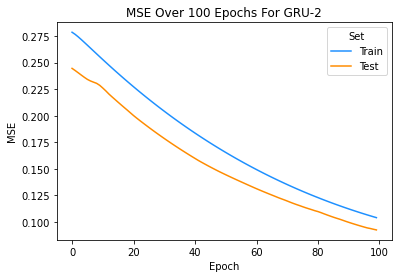

In [504]:
import matplotlib.pyplot as plt

plt.plot(df5["Epoch"], df5["Training_Loss"]/2048, color = "dodgerblue")
plt.plot(df5["Epoch"], df5["Test_Loss"]/2048, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 100 Epochs For GRU-2")
plt.legend(["Train", "Test"], title = "Set" )

plt.show()

# CNN-LSTM

In [622]:
# LSTM 2
class LSTM2(nn.ModuleList):
  def __init__(self):
    super(LSTM2, self).__init__()
    # Number of samples per time step
    self.batch_size = 2048
    
    # Dimension of weight vectors
    self.hidden_dim = 128
    
    # Dimension of embedded tensor
    self.embedding_dim = 1235
    
    # The vocabulary size
    self.input_size = 2470
    
    # Number of time steps
    self.sequence_len = 2
    
    # Initialize embedding layer
    self.embedding = nn.Embedding(self.input_size, self.embedding_dim, padding_idx=0)
    
    # Initialize LSTM Cell
    self.lstm_cell = nn.LSTMCell(self.embedding_dim, self.hidden_dim)


    # Initialize LSTM Cell for the first layer
    self.lstm_cell_1 = nn.LSTMCell(self.embedding_dim, self.hidden_dim)

    # Initialize LSTM Cell for the second layer
    self.lstm_cell_2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)

    self.fully_connected = nn.Linear(128, 64)
    self.lrelu = nn.LeakyReLU(negative_slope=2)
    self.nrelu = nn.LeakyReLU(negative_slope=2)
    self.fc2 = nn.Linear(64, 1)
    self.fc3 = nn.Linear(12, 1)


    self.layers = nn.Sequential( nn.Linear(128,64),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01), 
                                
                                nn.Linear(64,12),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01),
                                nn.Linear(12,1),
                                nn.Dropout(p=0),
                                nn.LeakyReLU(negative_slope=0.01))
    
    self.con_test = nn.Sequential(nn.Conv1d(in_channels=1, out_channels = 12, kernel_size= 240), 
                                  nn.Conv1d(in_channels = 12, out_channels = 2, kernel_size= 240),
                                  nn.Flatten(), nn.Linear(3984, 2470), nn.LeakyReLU())


  def forward(self, x):
    #print(x.shape)
    x = self.con_test(x)
    #print(out.shape)
    #kill = 3/0
    # batch_size x hidden_size
    hidden_state = torch.zeros(x.size(0), self.hidden_dim)
    cell_state = torch.zeros(x.size(0), self.hidden_dim)
    hidden_state_2 = torch.zeros(x.size(0), self.hidden_dim)
    cell_state_2 = torch.zeros(x.size(0), self.hidden_dim)

    hidden_state = hidden_state.to(device)
    cell_state = cell_state.to(device)
    hidden_state_2 = hidden_state_2.to(device)
    cell_state_2 = cell_state_2.to(device)
    
    # weights initialization
    torch.nn.init.xavier_normal_(hidden_state)
    torch.nn.init.xavier_normal_(cell_state)
    torch.nn.init.xavier_normal_(hidden_state_2)
    torch.nn.init.xavier_normal_(cell_state_2)
    
    # From idx to embedding
    #out = self.embedding(x)
    out = x
    
    # Prepare the shape for LSTMCell
    out = out.view(self.sequence_len, x.size(0), -1)
    
    # Unfolding LSTM
    # Last hidden_state will be used to feed the fully connected neural net
    for i in range(self.sequence_len):
      hidden_state, cell_state = self.lstm_cell_1(out[i], (hidden_state, cell_state))
      hidden_state_2, cell_state_2 = self.lstm_cell_2(hidden_state, (hidden_state_2, cell_state_2))
      
    # Last hidden state is passed through a fully connected neural net
    #print(hidden_state_2.shape)
    out = self.layers(hidden_state_2)
    #out = self.fully_connected(hidden_state_2)	
    #out = self.lrelu(out)
    #out = self.fc2(out)
    #out = self.nrelu(out)
    #out = self.fc3(out)    
    return out

In [623]:
#rnn = nn.RNN(input_size = 2470, hidden_size= 128, num_layers=1 , batch_first=True )
from torch.autograd import Variable 

rnn = LSTM2()

loss_fn = nn.MSELoss()

torch.manual_seed(5)

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-5, weight_decay=1e-5)

results4 = []

for epoch in range(0, 100):
  print("Epoch: ", epoch)
  # train
  tr_loss = 0.0
  rnn.train()

  for x, y in train_loader:
    rnn = rnn.to(device)
    x = x.to(device)
    #print(x.shape)
    #print(x.shape[0])
    x = torch.reshape(x,(x.shape[0],1, 2470))
    #x = x.long()

    output = rnn(x)
    #print("O: ", output.shape)

    y = y.to(device)
    loss = loss_fn(output, y)
    loss.backward()

    # step
    optimizer.step()

    # update loss 
    tr_loss += loss.item()

    
  print(tr_loss)

  # test
  test_loss = 0.0
  rnn.eval()

  yhat = []
  yreal = []
  for x, y in test_loader:
    x = x.to(device)
    x = nn.functional.pad(x, (1,191), "constant", 0)
    x = torch.reshape(x,(x.shape[0],1, 2470))

    test_out = rnn(x)

    bsize = test_out.shape[0]
    if(epoch == 99):
      for i in range(bsize):
        yhat.append(test_out[i].tolist()[0])
        yreal.append(y[i].tolist()[0])


    y = y.to(device)
    loss = loss_fn(test_out, y)
    #loss.backward()
    optimizer.step()

    test_loss += loss.item()

  print(test_loss)






  new_row = {"Epoch":epoch, "Training_Loss":tr_loss, "Test_Loss":test_loss}
  results4.append(new_row)







"""
for x, y in train_loader:
  print(x[0])
  print(y[0])
  print(x.shape)
  x = torch.reshape(x,(512,1, 2470))
  print(x.shape)
  out, h_n = rnn(x) 
  break
"""

Epoch:  0
543.9446568489075
477.84624004364014
Epoch:  1
541.5289816856384
475.2434549331665
Epoch:  2
538.1611137390137
471.92378520965576
Epoch:  3
533.9028820991516
467.85770082473755
Epoch:  4
529.3620624542236
463.7075777053833
Epoch:  5
524.7625350952148
459.86525201797485
Epoch:  6
520.6015753746033
456.15680170059204
Epoch:  7
516.3036518096924
452.24257946014404
Epoch:  8
511.87488985061646
448.3355860710144
Epoch:  9
507.4147071838379
444.1357192993164
Epoch:  10
502.36700534820557
439.33962297439575
Epoch:  11
496.7075529098511
433.9550061225891
Epoch:  12
490.44233536720276
428.5758662223816
Epoch:  13
484.1066720485687
422.8274817466736
Epoch:  14
477.62223052978516
416.95054173469543
Epoch:  15
470.5312476158142
410.4728636741638
Epoch:  16
463.272828578949
403.8752074241638
Epoch:  17
455.5630979537964
396.93536138534546
Epoch:  18
447.5337302684784
389.8290820121765
Epoch:  19
439.40736293792725
382.51958990097046
Epoch:  20
430.630891084671
374.0640377998352
Epoch:  21

'\nfor x, y in train_loader:\n  print(x[0])\n  print(y[0])\n  print(x.shape)\n  x = torch.reshape(x,(512,1, 2470))\n  print(x.shape)\n  out, h_n = rnn(x) \n  break\n'

10
6.796450829325516
5.7964483005497165
4.796692894369258
3.7967026200194964
0.7882525914245182
-0.2116172711054484
-1.2113754837362616
-2.2115915009259566
[6.796450829325516, 5.7964483005497165, 4.796692894369258, 3.7967026200194964, 0.7882525914245182, -0.2116172711054484, -1.2113754837362616, -2.2115915009259566]


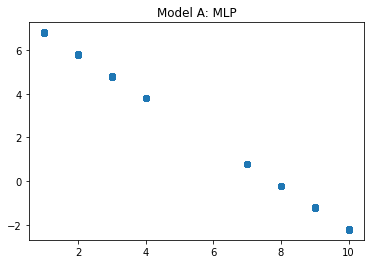

In [624]:
import matplotlib.pyplot as plt

difference = []

mean_diffs = [[],[],[],[],[],[],[],[],[],[]]
print(len(mean_diffs))
for i in range(len(yhat)):
  d = yhat[i] - float(yreal[i])
  difference.append(d)
  #print(int(yreal[i]))
  mean_diffs[(int(yreal[i])-1)].append(d)

final_mean_diffs = []

for i in range(len(mean_diffs)):
  try:
    print(sum(mean_diffs[i])/ len(mean_diffs[i]))
    avgd = sum(mean_diffs[i])/ len(mean_diffs[i])
    final_mean_diffs.append(avgd)
  except:
    print("", end= "")
    #final_mean_diffs.append(0)

print(final_mean_diffs)

xs = [1,2,3,4,7,8,9,10]

plt.title("Model A: MLP")
plt.scatter(yreal, difference)
plt.show()


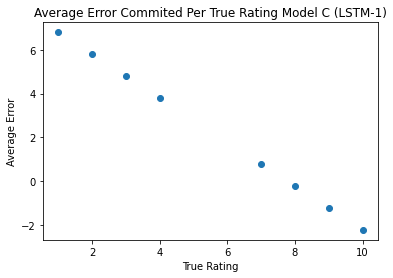

In [625]:
plt.scatter(xs, final_mean_diffs)
plt.title("Average Error Commited Per True Rating Model C (LSTM-1)")
plt.xlabel("True Rating")
plt.ylabel("Average Error")
plt.show()
meta_diffs_save.append(final_mean_diffs)

In [505]:
df5 = pd.DataFrame(results4)
df5.head()

df5.sort_values(by = "Test_Loss").head()

,Epoch,Training_Loss,Test_Loss
57,57,154.136909,145.023659
56,56,155.122021,145.130843
58,58,153.556569,145.279519
55,55,156.525118,145.613267
59,59,153.366961,145.886431


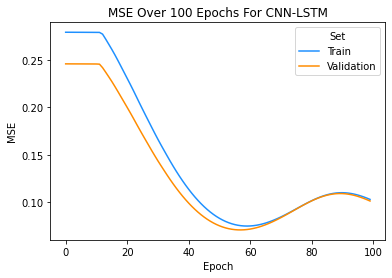

In [508]:
import matplotlib.pyplot as plt

plt.plot(df5["Epoch"], df5["Training_Loss"]/2048, color = "dodgerblue")
plt.plot(df5["Epoch"], df5["Test_Loss"]/2048, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 100 Epochs For CNN-LSTM")
plt.legend(["Train", "Validation"], title = "Set" )

plt.show()

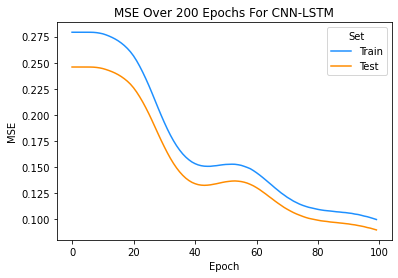

In [443]:
import matplotlib.pyplot as plt

plt.plot(df5["Epoch"], df5["Training_Loss"]/2048, color = "dodgerblue")
plt.plot(df5["Epoch"], df5["Test_Loss"]/2048, color = "darkorange")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE Over 200 Epochs For CNN-LSTM")
plt.legend(["Train", "Test"], title = "Set" )

plt.show()

# Aggregate Visualization

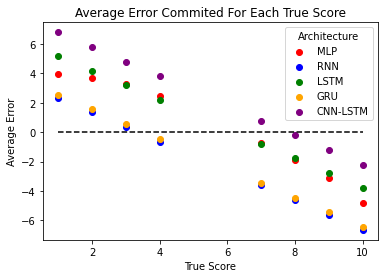

In [651]:
plt.scatter(xs, meta_diffs_save[0], color= "red")
plt.scatter(xs, meta_diffs_save[1], color= "blue")
plt.scatter(xs, meta_diffs_save[2], color= "green")
plt.scatter(xs, meta_diffs_save[3], color= "orange")
plt.scatter(xs, meta_diffs_save[4], color= "purple")

plt.legend(["MLP", "RNN", "LSTM", "GRU", "CNN-LSTM"], title = "Architecture" )
plt.plot(xs, [0,0,0,0,0,0,0,0], linestyle = 'dashed', color = "black")
plt.title("Average Error Commited For Each True Score")
plt.xlabel("True Score")
plt.ylabel("Average Error")
plt.show()

In [627]:
xs

[1, 2, 3, 4, 7, 8, 9, 10]

In [635]:
len(meta_diffs_save)

5

In [626]:
meta_diffs_save


[[3.9826509320969907,
  3.653916366837294,
  3.310600705026272,
  2.4934723858620824,
  -0.755933402099695,
  -1.8862142715813583,
  -3.1357301495327436,
  -4.795108168139063],
 [2.3268760812087916,
  1.3422035079329662,
  0.3566266908649383,
  -0.6377309439983042,
  -3.6113215139618626,
  -4.616145386556873,
  -5.624743058015635,
  -6.640417375862343],
 [5.15652894005037,
  4.172389991095617,
  3.189596166873114,
  2.212981247612859,
  -0.7778056215130116,
  -1.7688372725759531,
  -2.786206452916357,
  -3.7930758493953873],
 [2.5502254335303935,
  1.5507912597482252,
  0.5512687110000124,
  -0.4498274745253503,
  -3.442553816239039,
  -4.442064516836574,
  -5.44343492243741,
  -6.442504580965197],
 [6.796450829325516,
  5.7964483005497165,
  4.796692894369258,
  3.7967026200194964,
  0.7882525914245182,
  -0.2116172711054484,
  -1.2113754837362616,
  -2.2115915009259566]]